In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Reshape
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
#upload kaggle token file
from google.colab import files
files.upload()

In [3]:
#check the file
!ls -lrt kaggle.json

-rw-r--r-- 1 root root 64 Mar 11 18:06 kaggle.json


In [0]:
#Give file configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install kaggle
#Download competition data
!kaggle competitions download -c digit-recognizer

 85% 62.0M/73.2M [00:00<00:00, 60.4MB/s]
100% 73.2M/73.2M [00:00<00:00, 107MB/s] 
 94% 46.0M/48.8M [00:00<00:00, 30.0MB/s]
100% 48.8M/48.8M [00:00<00:00, 55.7MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 200MB/s]


In [0]:
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
sns.set(style='white', context='notebook', palette='deep')

In [7]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

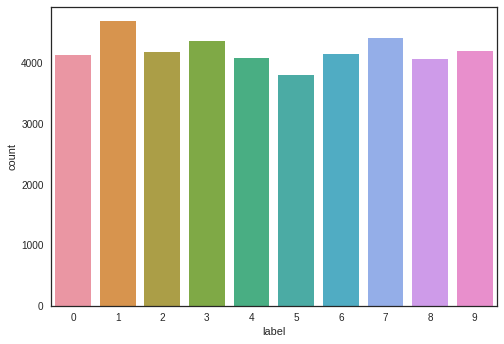

In [9]:
# Find the count of each digit available and plot
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)
del train
g = sns.countplot(Y_train)
Y_train.value_counts()

In [10]:
# Check for null or missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
# Normalise to make image to graysacle
X_train = X_train/255.0
test = test/255.0

In [0]:
# Reshape to 28x28x1 3D Matrix
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [0]:
# One hot code encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [0]:
random_seed = 2
# Test train split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

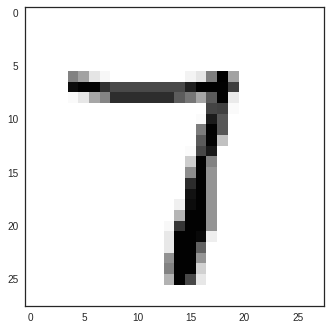

In [16]:
plt.imshow(X_train[1][:,:,0])

In [17]:
# Set Up CNN Model
# CNN Architecture => In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Reshape((7 * 7 * 64, )))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
# Learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs = 1
batch_size=86

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(X_train)

In [28]:
# Model Fitting
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs = epochs, validation_data = (X_val, Y_val),
                             verbose = 2, steps_per_epoch=X_train.shape[0],
                             callbacks=[learning_rate_reduction])

Epoch 1/1
 - 1140s - loss: 0.7411 - acc: 0.9538 - val_loss: 0.4797 - val_acc: 0.9702


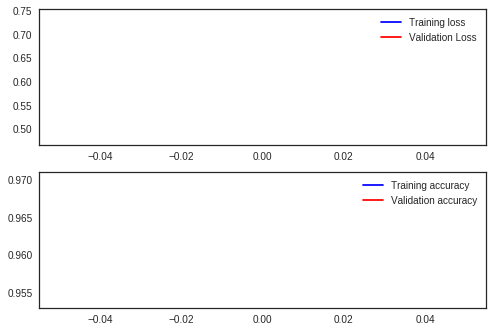

In [30]:
# Plot curve
fig,ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

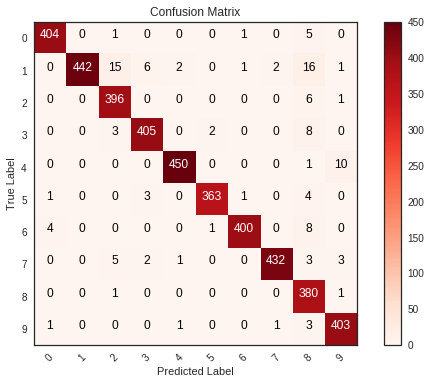

In [31]:
# Create Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
            horizontalalignment="center",
            color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10))

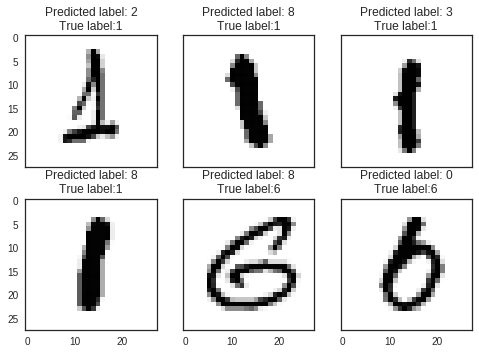

In [32]:
# Find errors
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
  n=0
  nrows = 2
  ncols = 3
  fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
  for row in range(nrows):
    for col in range(ncols):
      error = errors_index[n]
      ax[row, col].imshow((img_errors[error]).reshape((28,28)))
      ax[row, col].set_title("Predicted label: {}\nTrue label:{}".format(pred_errors[error], obs_errors[error]))
      n += 1
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [0]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis=1)
submission.to_csv("cnn_mnist_datagen.csv", index=False)